<a href="https://colab.research.google.com/github/DannyTheFlower/PDA_Course/blob/main/practices/practice_2/PDA_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Настройка библиотек

### pandas

Для его настройки достаточно просто сделать импорт.

Также добавим numpy и matplotlib - пригодится для быстрых преобразований данных и визуализаций.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### pyspark

PySpark прежде всего требует установки самого Spark и платформы Java. Установим свободный JDK (Java development kit) версии 8. А Apache Spark скачаем версии 3.5.0 с Hadoop.

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

После этого в окружение среды нужно указать пути JAVA_HOME и SPARK_HOME на скачанные программы. Поскольку мы напрямую загрузили Spark, то он находится в директории content. Чтобы их добавить воспользуемся модулем os, который предоставляет интерфейс для взаимодействия с файловой системой.

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.5.0-bin-hadoop3"

Чтобы использовать PySpark как обычную Python-библиотеку, установим findspark, который сделает за нас остальную работу по инициализации.

In [4]:
!pip install findspark

Осталось инициализировать PySpark. Для этого вызывается метод findspark.init(), а дальше создаём точку входа кластера.

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession, functions
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Загрузка данных

Очень часто при анализе данных мы работаем с датасетами Kaggle — онлайн-площадки для соревнований по машинному обучению как в рамках конкурсов, так и для личных исследований. Обычно датасеты с Kaggle скачиваются напрямую на компьютер. Потом их загружают либо в Google Colab, либо в Google Drive. Причём если они загружаются с Drive, то придётся также их подгружать в Colab и вводить код доступа. Оба метода достаточно долгие, особенно если файлы большого размера. Поэтому загрузим файлы напрямую с Kaggle в Colab через Kaggle API.

Для этого, прежде всего необходимо создать аккаунт Kaggle (если у вас его еще нет). А затем в настройках аккаунта нужно создать API Token. Рисунок ниже показывает соответствующий раздел. После этого скачается файл kaggle.json, который содержит ваш личный код доступа.
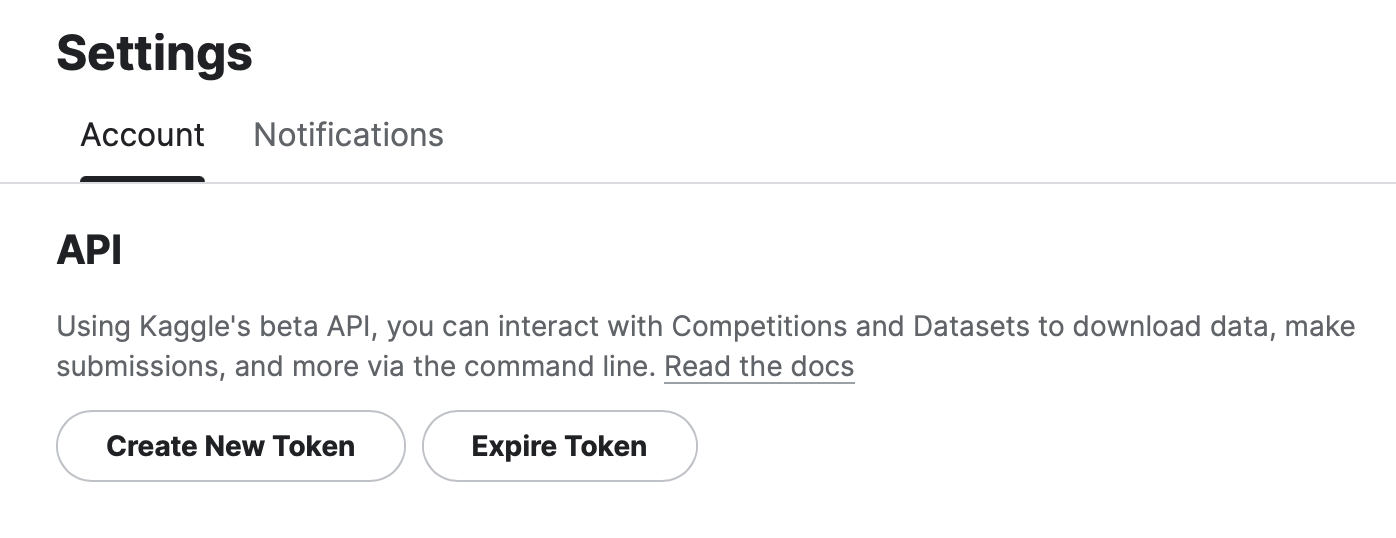

In [6]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"daniilpiatygo","key":"6a5c15c37176a5dd0af08791f3882e69"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

В этой и следующей практиках будем работать с [датасетом](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset), предназначенным для обучения алгоритма рекомендаций книг.

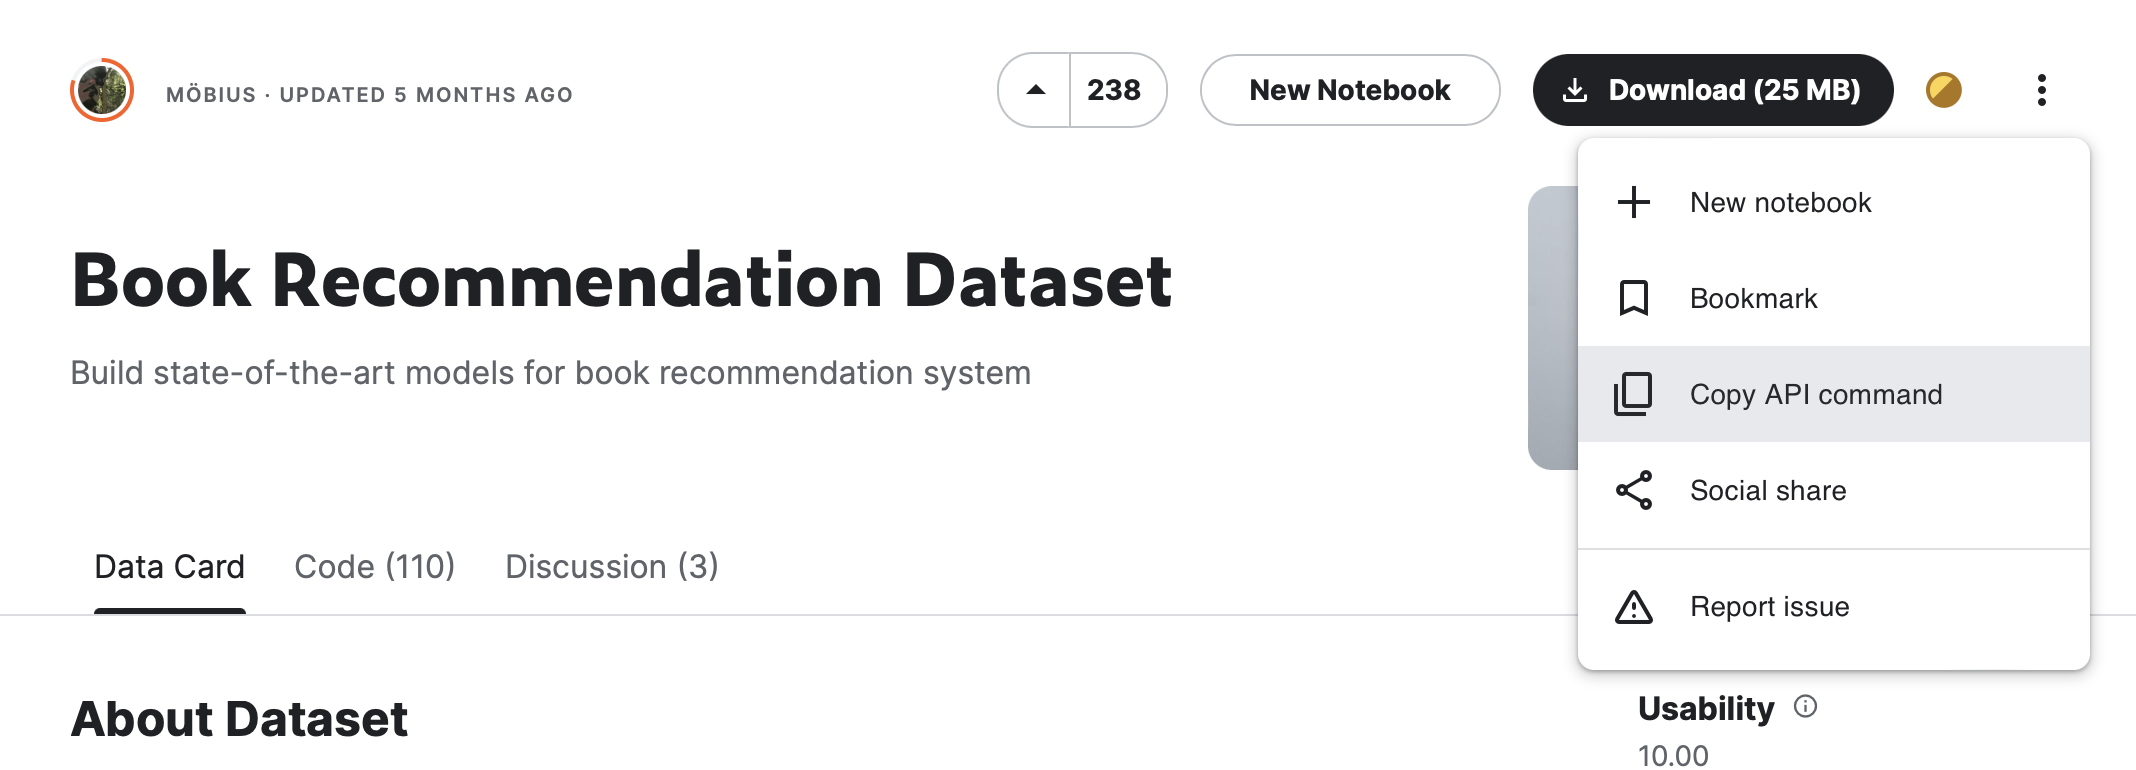

In [7]:
!kaggle datasets download -d arashnic/book-recommendation-dataset

 46% 11.0M/23.8M [00:00<00:00, 113MB/s]
100% 23.8M/23.8M [00:00<00:00, 163MB/s]


In [8]:
!unzip -q book-recommendation-dataset.zip

## Упражнения с данными в pandas

### Подготовка

Загрузим данные и посмотрим на них: выведите по 3 первые строки каждого датафрейма с помощью метода  [head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html).

In [59]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

display(books.head(3))
display(ratings.head(3))
display(users.head(3))

<ipython-input-59-3b325d4d72fd>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


Посмотрим на размеры датафреймов.

In [60]:
books.shape, ratings.shape, users.shape

((271360, 8), (1149780, 3), (278858, 3))

Воспользуйтесь [функцией](https://pandas.pydata.org/docs/reference/api/pandas.merge.html#pandas.merge) или [методом](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) merge, чтобы объединить три датафрейма в один.

In [61]:
books = books.merge(ratings, on="ISBN").merge(users, on="User-ID")
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,"timmins, ontario, canada",NaN
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,"timmins, ontario, canada",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1031131,087004124X,Anthem,Ayn Rand,1966,Caxton Press,http://images.amazon.com/images/P/087004124X.0...,http://images.amazon.com/images/P/087004124X.0...,http://images.amazon.com/images/P/087004124X.0...,259589,8,"venice, florida, usa",19.0
1031132,158243123X,A Student of Weather,Elizabeth Hay,2001,Counterpoint Press,http://images.amazon.com/images/P/158243123X.0...,http://images.amazon.com/images/P/158243123X.0...,http://images.amazon.com/images/P/158243123X.0...,259591,8,"tioga, pennsylvania, usa",39.0
1031133,8485900057,Rimas y leyendas (ClÃ¡sicos Fraile ; 3),Gustavo Adolfo BÃ©cquer,1981,Ediciones Fraile,http://images.amazon.com/images/P/8485900057.0...,http://images.amazon.com/images/P/8485900057.0...,http://images.amazon.com/images/P/8485900057.0...,259614,10,"madrid, madrid, spain",22.0
1031134,0838934854,Anglo-American Cataloguing Rules,Michael Gorman,1998,American Library Association,http://images.amazon.com/images/P/0838934854.0...,http://images.amazon.com/images/P/0838934854.0...,http://images.amazon.com/images/P/0838934854.0...,259679,6,"grand prairie, texas, usa",27.0


В столбце Location указано достаточно много данных: город, регион, страна. Давайте разделим этот столбец на три с помощью метода [str.split()](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html) с параметром expand=True. Если в процессе у вас образовались лишние столбцы, удалите их методом [drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) с параметром inplace=True, чтобы не создавать новую таблицу. Это случилось потому, что со столбцом с локацией есть некоторые проблемы, но мы на них сейчас не будем обращать внимание.

In [62]:
locations = books["Location"].str.split(", ", expand=True)
locations.drop(range(3, 7), axis=1, inplace=True)
locations.columns = ["city", "region", "country"]
books = pd.concat([books, locations], axis=1)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,city,region,country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0,stockton,california,usa
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN,timmins,ontario,canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",NaN,timmins,ontario,canada
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,"timmins, ontario, canada",NaN,timmins,ontario,canada
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,"timmins, ontario, canada",NaN,timmins,ontario,canada


Узнаем немного больше о книгах и пользователях.
1. Построим [гистограмму](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) распределения возрастов пользователей. Видно, что там есть отсутствующие значения. Будем их пока игнорировать.

In [63]:
books.Age.describe()

count    753301.000000
mean         37.397648
std          14.098254
min           0.000000
25%          28.000000
50%          35.000000
75%          45.000000
max         244.000000
Name: Age, dtype: float64

Было бы неплохо не смотреть на то, что читают младенцы и мумии: посмотрим на возраст больше 0 и меньше 100. Для того, чтобы отсеять лишние строки, можно воспользоваться методом [query()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html).

В конце строки, отвечающей за вывод визуализации для вывода изображения без лишних указателей, можно поставить `;` или в следующей строке написать plt.show().

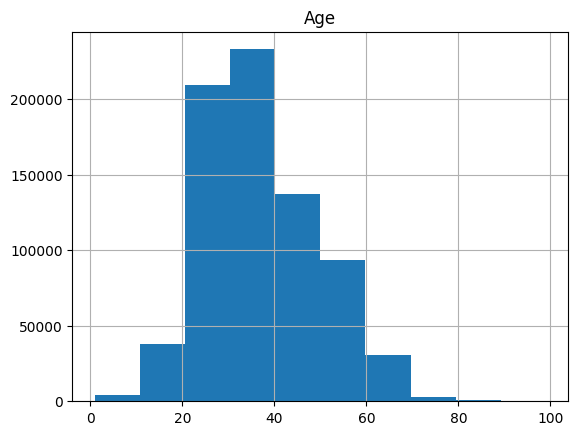

In [64]:
books.query("Age > 0 and Age < 100")["Age"].hist()
plt.title("Age")
plt.show()

Какой можно сделать вывод о возрасте пользователей?

*Большинство читающих пользователей имеют возраст 20-40 лет. Визуально распределение похоже на нормальное.*

Для пользователей с возрастом больше 100 лет поставим значение возраста np.nan. Можно сделать это с помощью метода [apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html), например.

In [65]:
books["Age"] = books["Age"].apply(lambda x: x if x <= 100 else np.nan)

2. Выясним, книги каких эпох представлены в датасете. Для этого построим еще диаграмму, теперь - с распределением кол-ва книг по годам.

TypeError: ignored

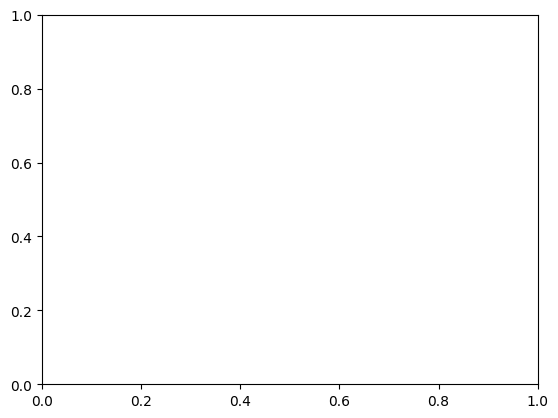

In [66]:
books["Year-Of-Publication"].hist()
plt.title("Year-Of-Publication")
plt.show()

Вероятно, у вас возникла ошибка о невозможности сравнения строк и целых чисел. Посмотрите, нет ли чего несанкционированного в столбце с датой, например, выведя уникальные значения с помощью метода [unqiue()](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html).

In [67]:
books["Year-Of-Publication"].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1992, 1989, 1976, 1985, 1980, 1995, 1997, 1983, 1987, 1990,
       1982, 0, 1965, 1986, 1960, 1974, 1978, 1984, 1973, 1959, 1942,
       1979, 1972, 1981, 1957, 1971, 1963, 1958, 1966, 1930, 1969, 1953,
       1970, 1947, 1977, 1954, 1920, 1955, 1975, 1964, 1967, 2030, 2005,
       1951, 1927, 1961, 1968, 1962, 1948, 1925, 1923, '2002', '1994',
       '1970', '1990', '1998', '1991', '1989', '0', '2001', '1986',
       '1999', '2000', '1996', '1981', '1985', '1987', '1995', '2003',
       '1988', '1976', '1979', '1993', '1984', '1997', '1975', '1983',
       '1992', '1980', '1982', '2004', '1974', '1977', '1971', '1978',
       '1972', '1958', '1969', '1966', '1967', '1973', '1968', 1938, 1956,
       '1964', 1901, 1926, 1940, '1941', '1959', '1942', '1963', '1962',
       '1922', '1957', '1897', '1960', '1949', '1956', '1939', '1955',
       '1961', '1952', '1933', '1954', '1965', '1944', 1952, 2011, 

Часть чисел имеет вид строки - преобразовать не проблема. Но есть и две настоящих строки, на вид - названия издательств. Давайте посмотрим на строки с такими значениями.

In [68]:
books[(books["Year-Of-Publication"] == "Gallimard") | (books["Year-Of-Publication"] == "DK Publishing Inc")]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,city,region,country
287500,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN,137190,0,"rennes, bretagne, france",31.0,rennes,bretagne,france
352361,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,227771,7,"savion, n/a, israel",19.0,savion,n/a,israel
467962,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN,130571,0,"summerville, south carolina, usa",NaN,summerville,south carolina,usa
469216,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,169663,0,"towson, maryland, usa",NaN,towson,maryland,usa


В 4 строках некорректно открепили автора от названия. Для упрощения работы исключим эти строки из датасета.
>В качестве дополнительного упражнения верните порядок в эти строки с помощью pandas.

In [70]:
condition = (books["Year-Of-Publication"] == "Gallimard") | (books["Year-Of-Publication"] == "DK Publishing Inc")
books.loc[condition, ["Book-Author", "Year-Of-Publication"]] = books.loc[condition, ["Year-Of-Publication", "Book-Author"]].values

In [71]:
books[condition]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,city,region,country
287500,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",Gallimard,2003,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN,137190,0,"rennes, bretagne, france",31.0,rennes,bretagne,france
352361,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",DK Publishing Inc,2000,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,227771,7,"savion, n/a, israel",19.0,savion,n/a,israel
467962,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",DK Publishing Inc,2000,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN,130571,0,"summerville, south carolina, usa",NaN,summerville,south carolina,usa
469216,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",DK Publishing Inc,2000,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,169663,0,"towson, maryland, usa",NaN,towson,maryland,usa


Теперь продолжим с построением графика. Но сначала преобразуем весь столбец в целые числа с помощью метода [astype()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html).

In [74]:
books["Year-Of-Publication"] = books["Year-Of-Publication"].astype(int)

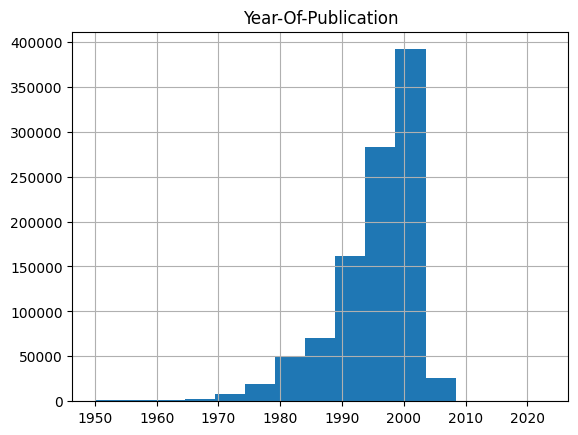

In [93]:
books["Year-Of-Publication"].hist(bins=15, range=(1950, 2023))
plt.title("Year-Of-Publication")
plt.show()

3. Покажем на [столбчатой диаграмме](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html) топ-5 стран, в которых живут пользователи из датасета. Для этого понадобится сгруппировать столбец со страной методом [groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html). Не забудьте отсортировать столбцы ([sort_values()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)).

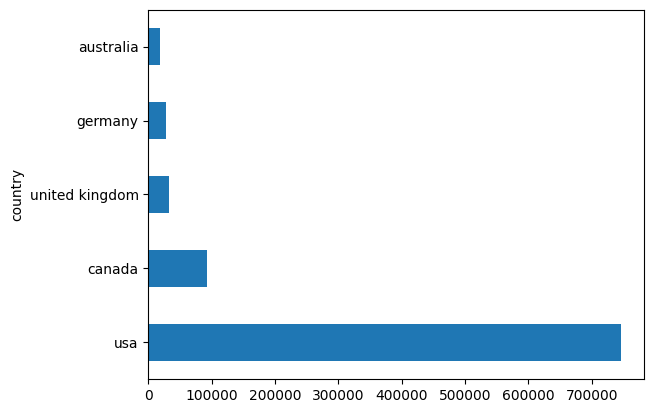

In [118]:
top5_countries = books.groupby("country").count().sort_values("ISBN", ascending=False).head(5)
top5_countries["ISBN"].plot.barh();

### Упражнения

Теперь выполним несколько упражнений с данными.

1. Найдите книги, которые оценивали и жители России, и жители США. Посчитайте, жители какой страны в среднем ставили более высокие оценки одним и тем же книгам. Ретинг 0 не учитывайте.

In [120]:
# найдём книги с российскими и американскими отзывами
russian_books = set(books[books["country"] == "russia"]["ISBN"])
usa_books = set(books[books["country"] == "usa"]["ISBN"])
common_books = russian_books.intersection(usa_books)
filtered_books = books[(books["ISBN"].isin(common_books)) & ((books["country"] == "russia") | (books["country"] == "usa"))]

In [124]:
# сгруппируем по странам и посчитаем средний рейтинг для каждой из них
filtered_books[filtered_books["Book-Rating"] > 0].groupby("country")["Book-Rating"].mean()

country
russia    8.142857
usa       7.959366
Name: Book-Rating, dtype: float64

*В среднем одним и тем же книгам россияне ставили более высокие оценки, чем жители США.*

2. Найдите год, в который было выпущено наибольшее количество книг. И год, в который наименьшее. Выведите годы и количество выпущенных книг.

In [136]:
# на ранних этапах можно было заметить, что много записей с годом публикации 0 — эти данные мы учитывать не будем
years_count = books[books["Year-Of-Publication"] > 0].groupby("Year-Of-Publication")["ISBN"].count().reset_index()
years_count = years_count.rename(columns={"ISBN": "Books-Count"})

max_year = years_count[years_count["Books-Count"] == years_count["Books-Count"].max()]
min_year = years_count[years_count["Books-Count"] == years_count["Books-Count"].min()]

In [137]:
print("Годы с минимальным количеством книг:")
min_year

Годы с минимальным количеством книг:


,Year-Of-Publication,Books-Count
0,1376,1
1,1378,1
2,1806,1
3,1897,1
7,1904,1
8,1906,1
11,1910,1
13,1914,1
14,1917,1
15,1919,1


In [138]:
print("Годы с максимальным количеством книг:")
max_year

Годы с максимальным количеством книг:


,Year-Of-Publication,Books-Count
98,2002,91800


## Упражнения с данными в pyspark

Повторим все те же действия, но с помощью PySpark.

### Подготовка

Загрузим данные и посмотрим на них. Метод show() зпускает выполнение операций, прописанных для датафрейма.

In [139]:
books = spark.read.option("header", True).csv("Books.csv")
ratings = spark.read.option("header", True).csv("Ratings.csv")
users = spark.read.option("header", True).csv("Users.csv")
books.show()
ratings.show()
users.show()

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|               2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|               2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|        Carlo D'Este|               1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari

Посмотрим на размеры датафреймов.

In [140]:
(books.count(), len(books.columns)), (ratings.count(), len(ratings.columns)), (users.count(), len(users.columns))

((271360, 8), (1149780, 3), (278859, 3))

Воспользуйтесь [функцией](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.join.html) join, чтобы объединить три датафрейма в один.

In [141]:
books = books.join(ratings, "ISBN").join(users, "User-ID")

In [142]:
(books.count(), len(books.columns))

(1031136, 12)

В столбце Location указано достаточно много данных: город, регион, страна. Давайте разделим этот столбец на три с помощью функции [split()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.split.html) и функции [withColumn()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.withColumn.html). Если в процессе у вас образовались лишние столбцы, удалите их методом [drop()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.drop.html). Это случилось потому, что со столбцом с локацией есть некоторые проблемы, но мы на них сейчас не будем обращать внимание.

In [145]:
splitted = functions.split(books["Location"], ", ")
books = books.withColumn("city", splitted.getItem(0))
books = books.withColumn("region", splitted.getItem(1))
books = books.withColumn("country", splitted.getItem(2))

In [147]:
books.show()

+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+----------+----------------+-------+
|User-ID|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|Book-Rating|            Location| Age|      city|          region|country|
+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+----------+----------------+-------+
|   1000|8850200005|Il Dio Delle Picc...|       Arundhati Roy|               2002|     Distribooks Inc|http://images.ama...|http://images.ama...|http://images.ama...|          0|teramo, abruzzo, ...|34.0|    teramo|         abruzzo|  italy|
| 100004|0345339703|The Fellowship o

Узнаем немного больше о книгах и пользователях.
1. Построим [гистограмму](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) распределения возрастов пользователей. Видно, что там есть отсутствующие значения. Будем их пока игнорировать.

In [148]:
books.describe(["Age"]).show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|            753333|
|   mean| 37.39758831409003|
| stddev|14.098294242258431|
|    min|      \""n/a\"""""|
|    max|              99.0|
+-------+------------------+



Для того, чтобы отсеять лишние строки, можно воспользоваться методом [filter()/where()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.filter.html).

Для сортировки можно воспользоваться методом [sort()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sort.html).

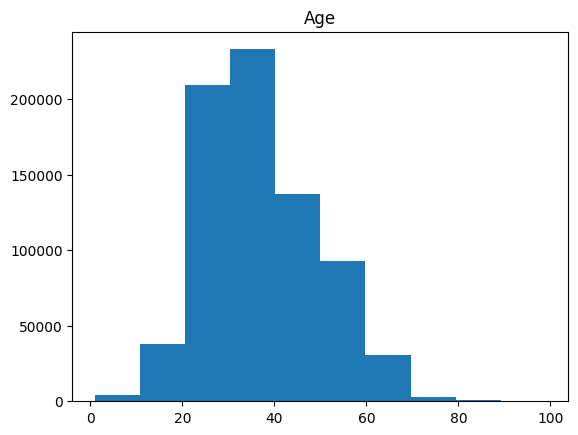

In [166]:
condition1 = ~functions.isnan(books["Age"]) & (books["Age"].isNotNull())
condition2 = functions.col("Age").cast("int") == functions.col("Age")
condition3 = (books["Age"] > 0) & (books["Age"] < 100)
books = books.filter(condition1 & condition2 & condition3)

age_data = [int(float(row["Age"])) for row in books.select("Age").collect()]
plt.hist(age_data)
plt.title("Age")
plt.show()

Какой можно сделать вывод о возрасте пользователей?

*Гистограмма получилась такой же, как и в Pandas, поэтому и вывод такой же :)*

2. Выясним, книги каких эпох представлены в датасете. Для этого построим еще диаграмму, теперь - с распределением кол-ва книг по годам.

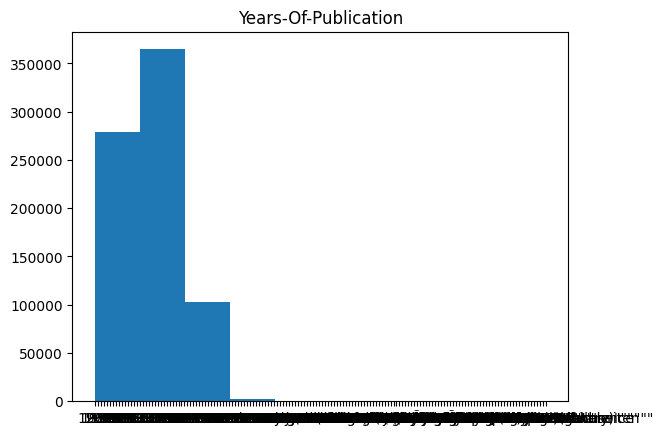

In [170]:
years = [row["Year-Of-Publication"] for row in books.select("Year-Of-Publication").collect()]
plt.hist(years)
plt.title("Years-Of-Publication")
plt.show()

Вероятно, у вас возникла ошибка о невозможности сравнения строк и целых чисел. Посмотрим на уникальные значения с помощью метода [distinct()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.distinct.html).

In [169]:
books.select("Year-Of-Publication").distinct().show()

+--------------------+
| Year-Of-Publication|
+--------------------+
|                1953|
|                1957|
|                1897|
|                1987|
|                1956|
|                1936|
|                2020|
|                1958|
|                1943|
|                1972|
|                1931|
| and tasty! : com...|
| and Musicians at...|
| and Box-Office M...|
|                1988|
|                1911|
|                1926|
|                1938|
|\"" \""Drachenste...|
|                1932|
+--------------------+
only showing top 20 rows



В 4 строках некорректно открепили автора от названия. Для упрощения работы исключим эти строки из датасета.

In [171]:
books = books.filter(functions.col("Year-Of-Publication").cast("int") == functions.col("Year-Of-Publication"))

Теперь продолжим с построением графика. Но сначала преобразуем весь столбец в целые числа с помощью метода [cast()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.cast.html).

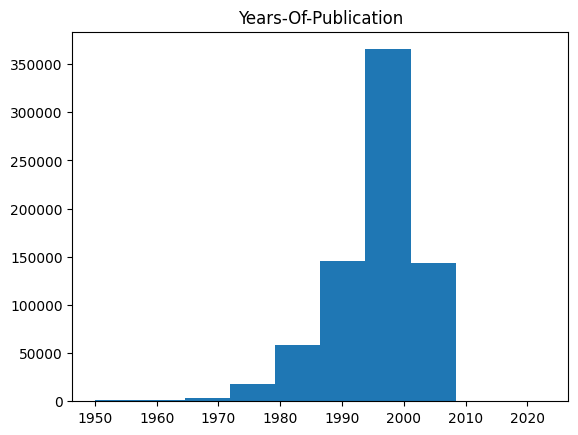

In [175]:
from pyspark.sql.types import IntegerType

books = books.withColumn("Year-Of-Publication", books["Year-Of-Publication"].cast(IntegerType()))
years = [row["Year-Of-Publication"] for row in books.select("Year-Of-Publication").collect()]
plt.hist(years, range=(1950, 2023))
plt.title("Years-Of-Publication")
plt.show()

3. Покажем на столбчатой диаграмме топ-5 стран, в которых живут пользователи из датасета. Для этого понадобится сгруппировать столбец со страной методом [groupBy()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html). Не забудьте отсортировать столбцы.

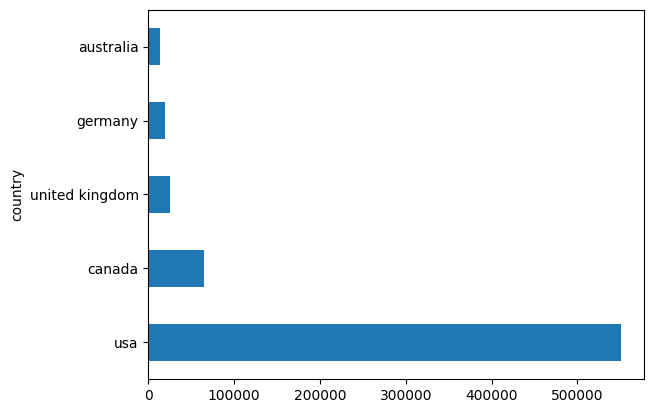

In [176]:
grouped_books = books.groupBy("country").count().sort("count", ascending=False)
top5_countries = grouped_books.limit(5).toPandas().set_index("country")

top5_countries["count"].plot.barh()
plt.show()

### Упражнения

Теперь выполним несколько упражнений с данными.

1. Найдите книги, которые оценивали и жители России, и жители США. Посчитайте, жители какой страны в среднем ставили более высокие оценки одним и тем же книгам. Ретинг 0 не учитывайте.

In [195]:
russian_books = [row["ISBN"] for row in books.filter(functions.col("country") == "russia").select("ISBN").distinct().collect()]
usa_books = [row['ISBN'] for row in books.filter(functions.col("country") == "usa").select("ISBN").distinct().collect()]
common_books = set(russian_books).intersection(set(usa_books))

filtered_books = books.filter((functions.col("ISBN").isin(common_books)) & ((functions.col("country") == "russia") | (functions.col("country") == "usa")))

result = filtered_books.filter(functions.col("Book-Rating") > 0).groupBy("country").agg(functions.avg("Book-Rating").alias("Average Rating"))
result.show()

+-------+-----------------+
|country|   Average Rating|
+-------+-----------------+
| russia|             9.25|
|    usa|8.035772357723577|
+-------+-----------------+



*Даже с учётом удалённых строк, загруженных с помощью pyspark некорректно, общая статистика сохраняется: одни и те же книги россияне оценивают книги более лояльно, чем жители США.*

2. Найдите год, в который было выпущено наибольшее количество книг. И год, в который наименьшее. Выведите годы и количество выпущенных книг.

In [192]:
years_count = books.filter(functions.col("Year-Of-Publication") > 0).groupBy("Year-Of-Publication").agg(functions.count("ISBN").alias("Books-Count")).sort("Year-Of-Publication")

max_count = years_count.agg(functions.max("Books-Count")).collect()[0][0]
min_count = years_count.agg(functions.min("Books-Count")).collect()[0][0]

max_year = years_count.filter(functions.col("Books-Count") == max_count)
min_year = years_count.filter(functions.col("Books-Count") == min_count)

In [193]:
print("Годы с минимальным количеством книг:")
min_year.show()

Годы с минимальным количеством книг:
+-------------------+-----------+
|Year-Of-Publication|Books-Count|
+-------------------+-----------+
|               1376|          1|
|               1378|          1|
|               1897|          1|
|               1909|          1|
|               1914|          1|
|               1917|          1|
|               1934|          1|
|               2008|          1|
|               2024|          1|
|               2037|          1|
+-------------------+-----------+



In [194]:
print("Годы с максимальным количеством книг:")
max_year.show()

Годы с максимальным количеством книг:
+-------------------+-----------+
|Year-Of-Publication|Books-Count|
+-------------------+-----------+
|               2002|      65571|
+-------------------+-----------+

